In [17]:

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [63]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 20
num_classes = 28
batch_size = 100
learning_rate = 0.001

In [64]:
class GetDataset(Dataset):
    

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        labels = self.landmarks_frame
        labels = np.array(labels)
        labels = labels.astype('float')
        
        A=[1]
        labels = np.vstack([A, labels])
        
        
        #print(labels.shape[0])
        #print(labels)
        get_label=labels[idx]
        
        
        
        
        labels=get_label.astype('float');
        
        
        str1= 'id_'+str(idx+1)+'_label_'+str(int(labels))+'.png';
        labels=labels-1;
        img_name = os.path.join(self.root_dir, str1)
        image = io.imread(img_name)
        
        sample = {'image': image, 'labels': labels}
        #print("idx", " ", idx, " ", "labels", labels)
        if self.transform:
            sample = self.transform(sample)

        return sample

In [65]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        #print(type(image))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}

In [66]:
transformed_dataset = GetDataset(csv_file='arabic_letters/csvTrainLabel 13440x1.csv',
                                           root_dir='arabic_letters/Train Images 13440x32x32/train',
                                           transform=transforms.Compose([
                                              
                                               ToTensor()
                                           ]))
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)       


In [67]:
test_dataset = GetDataset(csv_file='arabic_letters/csvTestLabel 3360x1.csv',
                                           root_dir='arabic_letters/Test Images 3360x32x32/test',
                                           transform=transforms.Compose([
                                              
                                               ToTensor()
                                           ]))

test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)


In [36]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

In [69]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [70]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [71]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=28):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [72]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [73]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [74]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Epoch [1/20], Step [100/135] Loss: 1.0102
Epoch [2/20], Step [100/135] Loss: 0.4414
Epoch [3/20], Step [100/135] Loss: 0.2471
Epoch [4/20], Step [100/135] Loss: 0.1875
Epoch [5/20], Step [100/135] Loss: 0.1765
Epoch [6/20], Step [100/135] Loss: 0.1968
Epoch [7/20], Step [100/135] Loss: 0.1248
Epoch [8/20], Step [100/135] Loss: 0.1904
Epoch [9/20], Step [100/135] Loss: 0.1215
Epoch [10/20], Step [100/135] Loss: 0.0682
Epoch [11/20], Step [100/135] Loss: 0.0557
Epoch [12/20], Step [100/135] Loss: 0.0622
Epoch [13/20], Step [100/135] Loss: 0.0829
Epoch [14/20], Step [100/135] Loss: 0.0458
Epoch [15/20], Step [100/135] Loss: 0.0630
Epoch [16/20], Step [100/135] Loss: 0.0389
Epoch [17/20], Step [100/135] Loss: 0.0763
Epoch [18/20], Step [100/135] Loss: 0.0213
Epoch [19/20], Step [100/135] Loss: 0.1477
Epoch [20/20], Step [100/135] Loss: 0.0637


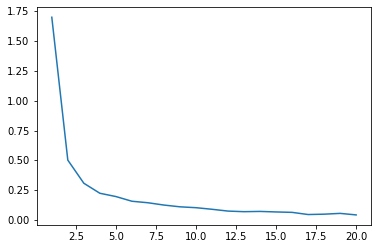

In [75]:
# Train the model
total_step = len(dataloader)
curr_lr = learning_rate
loss_vals=  []
for epoch in range(num_epochs):
    epoch_loss= []
    for i_batch, sample_batched in enumerate(dataloader):
        
        images=sample_batched['image'];
        labels=sample_batched['labels']
        images = images.unsqueeze(1)
        images = images.type(torch.FloatTensor)
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        labels= torch.reshape(labels, (-1,))
        labels = labels.to(dtype=torch.float32) 
        labels=labels.type(torch.LongTensor)
        
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        
        epoch_loss.append(loss.item())
        
        
        optimizer.step()
        
        if (i_batch+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i_batch+1, total_step, loss.item()))
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
        
my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)

In [77]:
#Training set accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i_batch, sample_batched in enumerate(dataloader):
        images=sample_batched['image'];
        labels=sample_batched['labels']
        images = images.unsqueeze(1)
        images = images.type(torch.FloatTensor)
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        labels= torch.reshape(labels, (-1,))
        labels = labels.to(dtype=torch.float32) 
        labels=labels.type(torch.LongTensor)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the train images: {} %'.format(100 * correct / total))

Accuracy of the model on the train images: 93.90579656224422 %


In [76]:
#Test set accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i_batch, sample_batched in enumerate(test_loader):
        images=sample_batched['image'];
        labels=sample_batched['labels']
        images = images.unsqueeze(1)
        images = images.type(torch.FloatTensor)
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        labels= torch.reshape(labels, (-1,))
        labels = labels.to(dtype=torch.float32) 
        labels=labels.type(torch.LongTensor)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 90.41381363501041 %
